In [7]:
# Wine + Agglomerative (dendrogram + silhouette to pick n_clusters) + PCA3 + cluster profiling

In [9]:
# STEP 1: Imports

In [48]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings; warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")

In [50]:
# STEP 2: Load and scale

In [52]:
wine = load_wine()
wine

{'data': array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
         1.185e+03],
        ...,
        [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
         8.350e+02],
        [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
         8.400e+02],
        [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
         5.600e+02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [54]:
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name="class")
X_scaled = StandardScaler().fit_transform(X)

In [56]:
# STEP 3: Dendrogram to feel structure

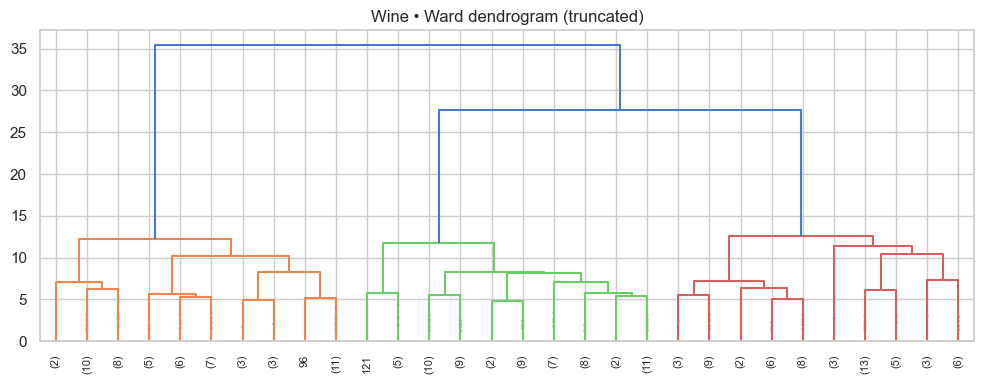

In [63]:
Z = linkage(X_scaled, method="ward")
plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90., leaf_font_size=8., show_contracted=True)
plt.title("Wine • Ward dendrogram (truncated)"); plt.tight_layout(); plt.show()

In [65]:
# STEP 4: Pick n_clusters via silhouette sweep

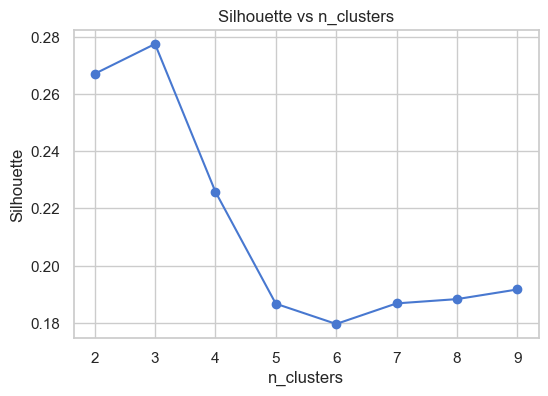

In [67]:
cand = list(range(2, 10))
sils = []
for k in cand:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labs = model.fit_predict(X_scaled)
    sils.append(silhouette_score(X_scaled, labs))
plt.figure(figsize=(6,4))
plt.plot(cand, sils, marker="o"); plt.title("Silhouette vs n_clusters"); plt.xlabel("n_clusters"); plt.ylabel("Silhouette"); plt.show()
k_best = cand[int(np.argmax(sils))]

In [69]:
# STEP 5: Fit final model

In [71]:
agg = AgglomerativeClustering(n_clusters=k_best, linkage="ward")
labels = agg.fit_predict(X_scaled)

In [73]:
# STEP 6: PCA 3D plot

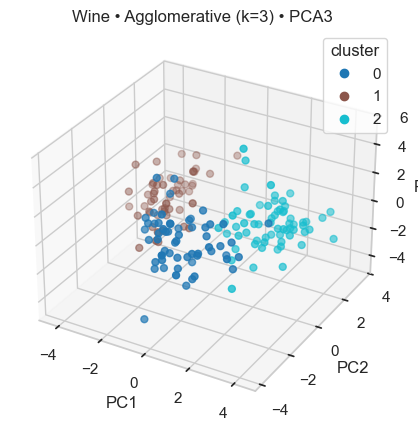

In [75]:
pca = PCA(n_components=3, random_state=42)
Xp3 = pca.fit_transform(X_scaled)
from mpl_toolkits.mplot3d import Axes3D  # noqa
fig = plt.figure(figsize=(7,5)); ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Xp3[:,0], Xp3[:,1], Xp3[:,2], c=labels, s=25, cmap="tab10")
ax.set_title(f"Wine • Agglomerative (k={k_best}) • PCA3"); ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), title="cluster"); plt.show()

In [77]:
# STEP 7: Profiling and metrics

In [79]:
sil = silhouette_score(Xs, labels)
ari = adjusted_rand_score(y, labels)
df_prof = pd.DataFrame(X_scaled, columns=wine.feature_names).assign(cluster=labels)
prof = df_prof.groupby("cluster").mean()
print({"n_clusters":k_best, "silhouette":round(sil,3), "ARI_vs_true":round(ari,3)})
display(prof.round(2))

{'n_clusters': 3, 'silhouette': 0.277, 'ARI_vs_true': 0.79}


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
cluster,,,,,,,,,,,,,
0,-0.98,-0.36,-0.55,0.21,-0.50,-0.05,0.06,-0.05,0.17,-0.94,0.45,0.35,-0.78
1,0.08,0.75,0.17,0.45,0.01,-0.96,-1.19,0.71,-0.81,0.78,-1.04,-1.25,-0.39
2,0.83,-0.33,0.35,-0.59,0.45,0.89,0.98,-0.57,0.56,0.17,0.50,0.77,1.05
